# Wstęp
Wczytanie potrzebnych bibliotek i danych.

In [65]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from networkx.algorithms.community import girvan_newman

In [66]:
friends = pd.read_csv('friends.csv', delimiter = ',')

In [67]:
friends.head()

text           speaker  \
0  There's nothing to tell! He's just some guy I ...     Monica Geller   
1  C'mon, you're going out with the guy! There's ...    Joey Tribbiani   
2  All right Joey, be nice. So does he have a hum...     Chandler Bing   
3                           Wait, does he eat chalk?     Phoebe Buffay   
4                         (They all stare, bemused.)  Scene Directions   

   season  episode  scene  utterance  
0       1        1      1          1  
1       1        1      1          2  
2       1        1      1          3  
3       1        1      1          4  
4       1        1      1          5

# Przygotowanie danych
W tej sekcji zostanie sprawdzone czy są obecne braki danych, ile mamy wierszy danych, jakie postacie się pojawiły oraz z ilu sezonów serialu mamy dane.

In [68]:
friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67373 entries, 0 to 67372
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       67373 non-null  object
 1   speaker    67097 non-null  object
 2   season     67373 non-null  int64 
 3   episode    67373 non-null  int64 
 4   scene      67373 non-null  int64 
 5   utterance  67373 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.1+ MB


In [69]:
friends[friends['speaker'].isnull()]

text speaker  season  \
66     Push her down the stairs! Push her down the st...     NaN       1   
285                                           Goodnight.     NaN       1   
379                                            Oh! Yeah!     NaN       1   
1054                                            Shut up!     NaN       1   
1778   I'm on top of the world, looking down on creat...     NaN       1   
...                                                  ...     ...     ...   
65514                                        I'll do it!     NaN      10   
65538                                        I love you.     NaN      10   
66183                                                No!     NaN      10   
66716                                              Yeah.     NaN      10   
67015                                               Hey.     NaN      10   

       episode  scene  utterance  
66           1      2          9  
285          1     14         29  
379          2      3         25  
1054         4     12          5  
1778         7     11         10  
...        ...    ...        ...  
65514       12     11          9  
65538       12     11         33  
66183       14     10         17  
66716       16     12         14  
67015       17      9         31  

[276 rows x 6 columns]

In [70]:
friends_cleaned = friends.dropna(subset=['speaker'])

In [71]:
friends_cleaned.isnull().sum()

text         0
speaker      0
season       0
episode      0
scene        0
utterance    0
dtype: int64

In [72]:
friends_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67097 entries, 0 to 67372
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       67097 non-null  object
 1   speaker    67097 non-null  object
 2   season     67097 non-null  int64 
 3   episode    67097 non-null  int64 
 4   scene      67097 non-null  int64 
 5   utterance  67097 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.6+ MB


In [73]:
friends_cleaned.head()

text           speaker  \
0  There's nothing to tell! He's just some guy I ...     Monica Geller   
1  C'mon, you're going out with the guy! There's ...    Joey Tribbiani   
2  All right Joey, be nice. So does he have a hum...     Chandler Bing   
3                           Wait, does he eat chalk?     Phoebe Buffay   
4                         (They all stare, bemused.)  Scene Directions   

   season  episode  scene  utterance  
0       1        1      1          1  
1       1        1      1          2  
2       1        1      1          3  
3       1        1      1          4  
4       1        1      1          5

Widać, że wśród postaci pojawił się Scene Directions, czyli tak zwane didaskalia - wskazówki dotyczące sceny. Postanowiono zatem sprawdzić, jakie są unikalne wartości kolumny speaker, ponieważ w celu przeprowadzenia analizy potrzebujemy jedynie postaci występujących w serialu.

In [74]:
friends_cleaned['speaker'].unique()

array(['Monica Geller', 'Joey Tribbiani', 'Chandler Bing',
       'Phoebe Buffay', 'Scene Directions', '#ALL#', 'Ross Geller',
       'Rachel Green', 'Waitress', 'Paul the Wine Guy', 'Priest On Tv',
       'Franny', 'Customer', 'Marsha', 'Carol Willick', 'Judy Geller',
       'Susan Bunch', 'Barry Farber', 'Robbie', 'Bernice', 'Dr. Oberman',
       'Paula', 'Alan', 'The Guys', 'Lizzy', 'Guys', 'Leslie', 'Kiki',
       'Joanne', 'Receptionist', 'Pizza Guy', 'Both', 'Kid',
       'Angela Delveccio', 'Janice Litman Goralnik', 'Woman', 'Bob',
       'Aurora', 'Director', 'Jill Goodacre', 'Mr. Heckles', 'Paolo',
       'Shelley', 'Aunt Lillian', 'Nurse Sizemore', 'Andrea', 'Lowell',
       'Terry', 'Guy', 'Girl', 'Max', 'David', 'Sandy', 'Bobby Rush',
       'Dick Clark', 'Jay Leno', 'Nora Tyler Bing', 'Coma Guy',
       "Phoebe's Assistant", 'Roger', 'Joey Tribbiani Sr.',
       'Ronni Rapalono', 'Gloria Tribbiani', 'Lorraine', 'Kristin',
       'Fireman No. 1', 'Fireman No. 2', 'Fireman N

Wśród osób, których kwestie są opisane w zbiorze, są zupełnie nie potrzebne, zwłaszcza kewstie grupowe czy też te wypowiadane przez reżysera. Potrzebni są główni bohaterowie oraz ważne postacie poboczne, które mogły wnosić istotny wkład w dynamikę grupy. W tym celu postanowiono wybrać najważniejsze postacie występujące w serialu Friends.

In [75]:
characters = [
    'Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller', 'Rachel Green',
    'Carol Willick', 'Susan Bunch', 'Judy Geller', 'Jack Geller', 'Janice Litman Goralnik',
    'Mr. Heckles', 'Julie', 'Richard Burke', 'Estelle Leonard',
    'Pete Becker', 'Emily Waltham', 'Larry', 'Gunther', 'Frank Buffay Jr.', 'Tag Jones',
    'Kathy', 'Janine Lecroix', 'Barry Farber', 'Mona',
    'Elizabeth Stevens', 'Jill Green', 'Tag Jones', 'Amy Green', 'Melissa Warburton', 'Jessica Lockhart',
    'Mike Hannigan', 'Gavin Mitchell', 'Charlie Wheeler', 'David', 'Erica Ford',
    'Gary', 'David', 'Paul Stevens', 'Elizabeth Stevens', 'Eddie Menuek', 'Paolo', 'Fun Bobby',
    'Richard Crosby', 'Leonard Green', 'Sandra Green', 'Nora Tyler Bing',
    'Charles Bing', 'Helena Handbasket', 'Will Colbert',
    'Frank Buffay Sr.', 'Alice Knight',
    ]
friends_cleaned = friends_cleaned[friends_cleaned['speaker'].isin(characters)]

In [76]:
friends_cleaned.head()

text         speaker  season  \
0  There's nothing to tell! He's just some guy I ...   Monica Geller       1   
1  C'mon, you're going out with the guy! There's ...  Joey Tribbiani       1   
2  All right Joey, be nice. So does he have a hum...   Chandler Bing       1   
3                           Wait, does he eat chalk?   Phoebe Buffay       1   
5  Just, 'cause, I don't want her to go through w...   Phoebe Buffay       1   

   episode  scene  utterance  
0        1      1          1  
1        1      1          2  
2        1      1          3  
3        1      1          4  
5        1      1          6

In [77]:
friends_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54940 entries, 0 to 67372
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       54940 non-null  object
 1   speaker    54940 non-null  object
 2   season     54940 non-null  int64 
 3   episode    54940 non-null  int64 
 4   scene      54940 non-null  int64 
 5   utterance  54940 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [78]:
friends_cleaned.isnull().sum()

text         0
speaker      0
season       0
episode      0
scene        0
utterance    0
dtype: int64

# Analiza danych
Analiza popularności postaci

In [79]:
popularity = friends_cleaned.groupby(['speaker', 'season']).size().reset_index(name='utterance_count')
most_popular_per_season = popularity.loc[popularity.groupby('season')['utterance_count'].idxmax()]
print(most_popular_per_season)

           speaker  season  utterance_count
161    Ross Geller       1              973
162    Ross Geller       2              909
163    Ross Geller       3             1076
18   Chandler Bing       4              966
19   Chandler Bing       5              940
20   Chandler Bing       6             1037
153   Rachel Green       7             1092
154   Rachel Green       8             1082
23   Chandler Bing       9              906
170    Ross Geller      10              871


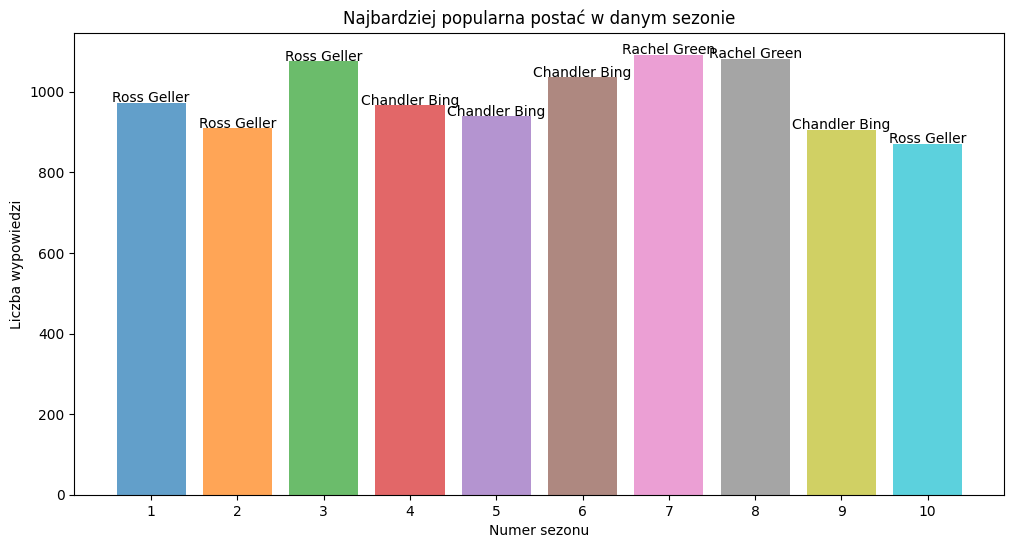

In [80]:
plt.figure(figsize=(12, 6))
for index, row in most_popular_per_season.iterrows():
    plt.bar(row['season'], row['utterance_count'], label=f"{row['speaker']}", alpha=0.7)
    plt.text(row['season'], row['utterance_count'] + 1, f"{row['speaker']}", ha='center')

plt.xlabel('Numer sezonu')
plt.ylabel('Liczba wypowiedzi')
plt.title('Najbardziej popularna postać w danym sezonie')
plt.xticks(range(1, len(popularity['season'].unique()) + 1))
plt.show()

Analiza interakcji między postaciami

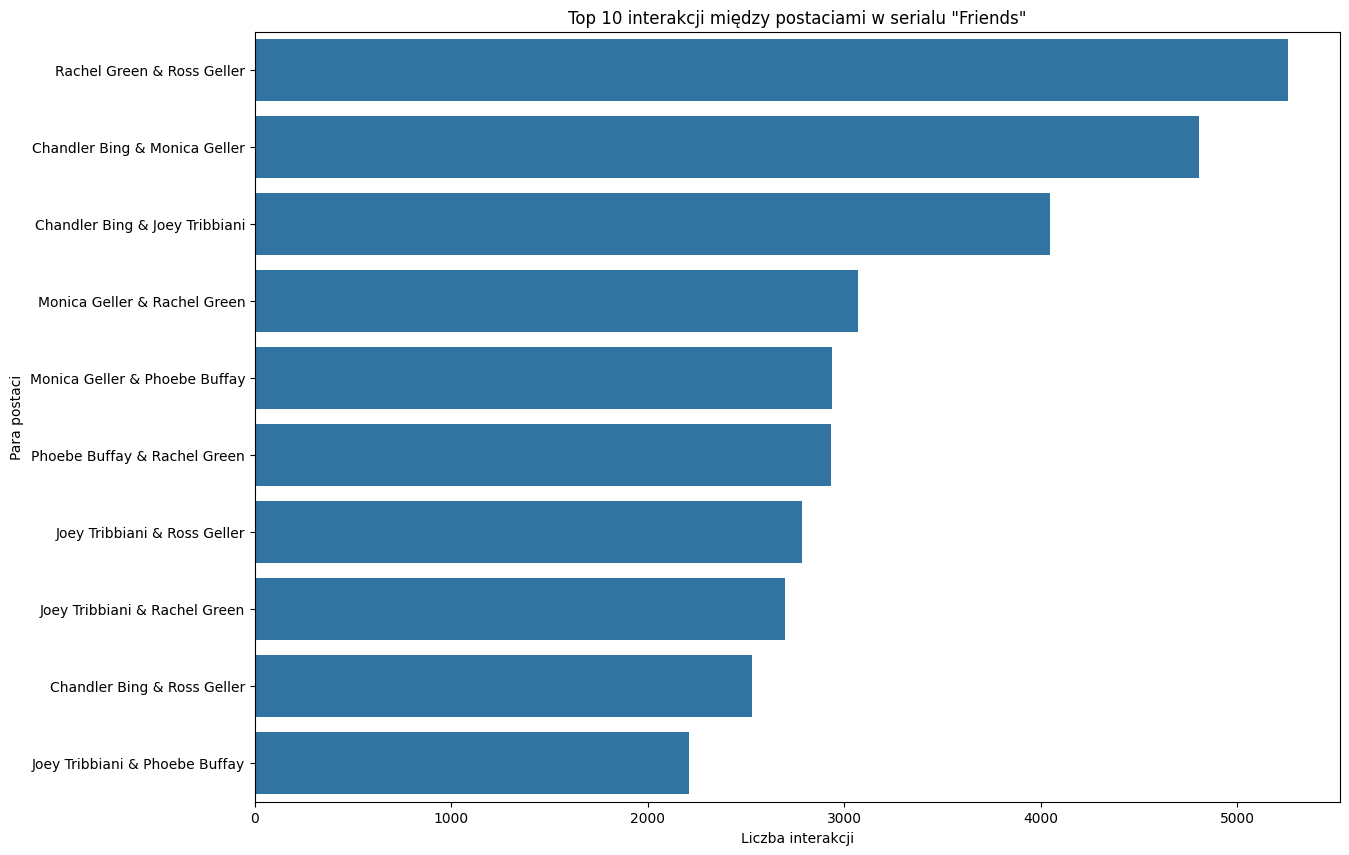

In [81]:
interaction_counts = defaultdict(int)

for i in range(len(friends_cleaned) - 1):
    speaker_1 = friends_cleaned.iloc[i]['speaker']
    speaker_2 = friends_cleaned.iloc[i + 1]['speaker']
    if speaker_1 != speaker_2:
        pair = tuple(sorted((speaker_1, speaker_2)))
        interaction_counts[pair] += 1

interaction_df = pd.DataFrame(interaction_counts.items(), columns=['pair', 'count'])
interaction_df[['speaker_1', 'speaker_2']] = pd.DataFrame(interaction_df['pair'].tolist(), index=interaction_df.index)
interaction_df = interaction_df.drop(columns=['pair'])

top_interactions = interaction_df.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(14, 10))
sns.barplot(data=top_interactions, x='count', y=top_interactions.apply(lambda x: f"{x['speaker_1']} & {x['speaker_2']}", axis=1))
plt.xlabel('Liczba interakcji')
plt.ylabel('Para postaci')
plt.title('Top 10 interakcji między postaciami w serialu "Friends"')
plt.show()

Analiza tematów rozmów

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['nothing', 'tell', 'guy', 'work', 'going', 'guy', 'got', 'ta', 'something', 'wrong', 'right', 'joey', 'nice', 'hump', 'hump', 'hairpiece', 'wait', 'eat', 'chalk', 'want', 'go', 'went', 'oh', 'okay', 'everybody', 'relax', 'even', 'date', 'two', 'people', 'going', 'dinner', 'sex', 'sounds', 'like', 'date', 'alright', 'back', 'high', 'school', 'standing', 'middle', 'cafeteria', 'realize', 'totally', 'naked', 'look', 'realize', 'phone', 'instead', 'right', 'never', 'dream', 'sudden', 'phone', 'starts', 'ring', 'know', 'everybody', 'starts', 'looking', 'looking', 'finally', 'figure', 'better', 'answer', 'turns', 'mother', 'weird', 'never', 'calls', 'hi', 'guy', 'says', 'hello', 'wan', 'na', 'kill', 'okay', 'sweetie', 'feel', 'like', 'someone', 'reached', 'throat', 'grabbed', 'small', 'intestine', 'pulled', 'mouth', 'tied', 'around', 'neck', 'cookie', 'carol', 'moved', 'stuff', 'today', 'ohh', 'let', 'get', 'coffee', 'thanks', 'ooh', 'oh', 'stop', 'cleansing', 'aura', 'leave', 'aura', 'alon

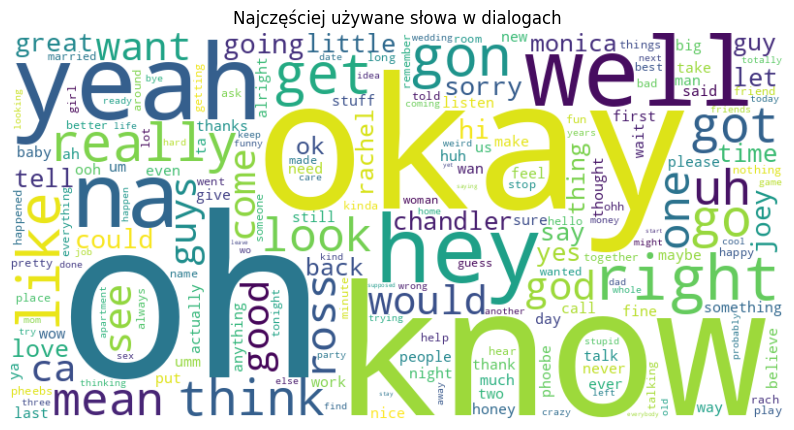

In [82]:
nltk.download('stopwords')
text_data = friends_cleaned['text'].str.lower().str.cat(sep=' ')
stop_words = set(stopwords.words('english'))

nltk.download('punkt')
tokens = word_tokenize(text_data)
filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]

print(filtered_words)

word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Najczęściej używane słowa w dialogach')
plt.show()

Analiza zmian w postaciach

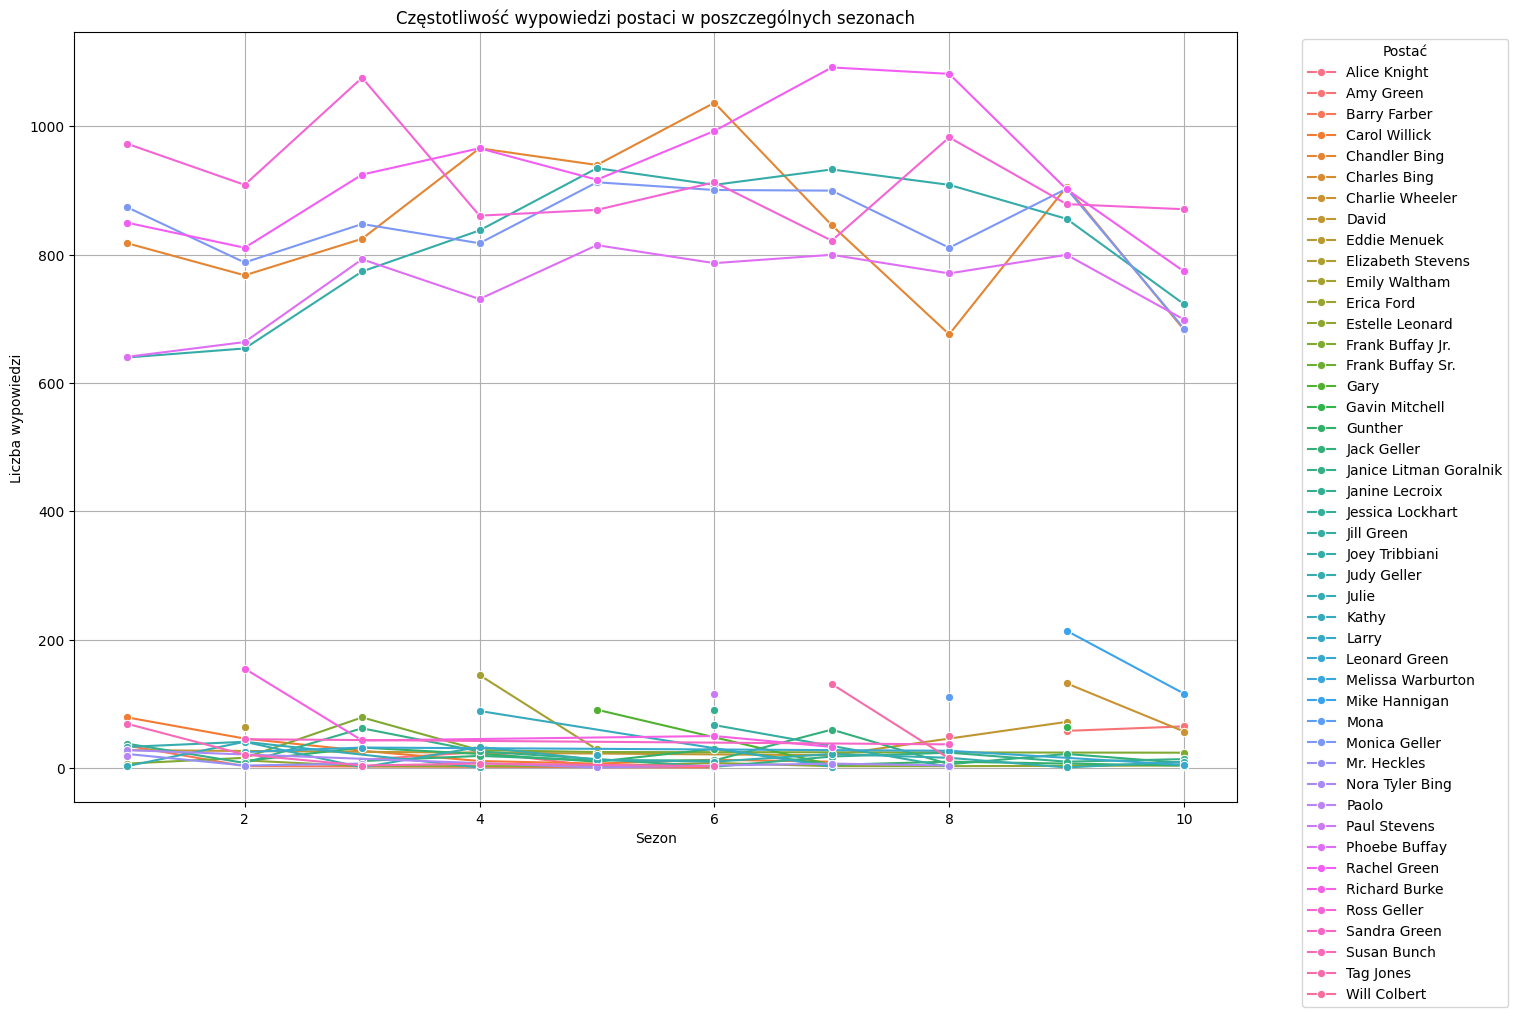

In [83]:
utterance_counts = friends_cleaned.groupby(['speaker', 'season']).size().reset_index(name='utterance_count')

plt.figure(figsize=(15, 10))
sns.lineplot(data=utterance_counts, x='season', y='utterance_count', hue='speaker', marker='o')
plt.title('Częstotliwość wypowiedzi postaci w poszczególnych sezonach')
plt.xlabel('Sezon')
plt.ylabel('Liczba wypowiedzi')
plt.legend(title='Postać', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

W tej części miały być sprawdzane top wyrazy w danym sezonie dla danej osoby, ale po sprawdzaniu kilku sezonów dla każdej z osób okazało się, że praktycznie nie ma żadnych zmian, więc nie uwzględnio tego w raporcie - jednak nudna informacja

In [84]:
def top_words_for_character_in_season(df, character, season, top_n=3):
    character_season = df[(df['speaker'] == character) & (df['season'] == season)]

    word_count = {}
    for text in character_season['text']:
        words = text.split()
        for word in words:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    top_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return top_words

top_words_for_character_in_season(friends_cleaned, 'Ross Geller', 6)

[('I', 404), ('you', 249), ('to', 196)]

# Analiza sieci interakcji między aktorami serialu "Friends"

In [85]:
G = nx.Graph()

characters = friends_cleaned['speaker'].unique()
G.add_nodes_from(characters)

for season, group in friends_cleaned.groupby('season'):
    for scene, scene_group in group.groupby('scene'):
        for combination in combinations(scene_group['speaker'].unique(), 2):
            if G.has_edge(*combination):
                G[combination[0]][combination[1]]['weight'] += 1
            else:
                G.add_edge(*combination, weight=1)

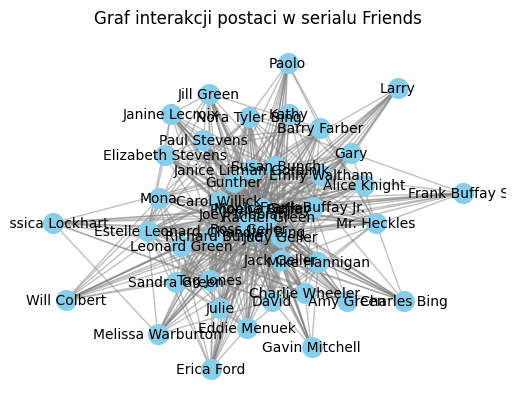

In [86]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_family="sans-serif")
plt.title("Graf interakcji postaci w serialu Friends")
plt.axis("off")
plt.show()

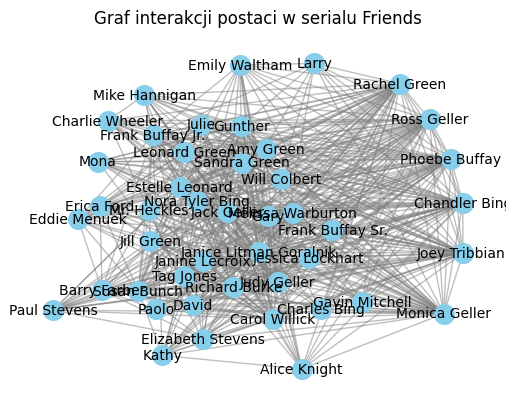

In [87]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_family="sans-serif")
plt.title("Graf interakcji postaci w serialu Friends")
plt.axis("off")
plt.show()

In [88]:
print(nx.density(G))
print(nx.transitivity(G))
print(G.nodes())
print(len(G.nodes()))
G.edges()
print(len(G.edges()))

0.5575757575757576
0.6765908510094557
['Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller', 'Rachel Green', 'Carol Willick', 'Judy Geller', 'Susan Bunch', 'Barry Farber', 'Janice Litman Goralnik', 'Mr. Heckles', 'Paolo', 'David', 'Nora Tyler Bing', 'Frank Buffay Jr.', 'Julie', 'Gunther', 'Estelle Leonard', 'Sandra Green', 'Erica Ford', 'Richard Burke', 'Eddie Menuek', 'Leonard Green', 'Jack Geller', 'Alice Knight', 'Kathy', 'Emily Waltham', 'Larry', 'Frank Buffay Sr.', 'Gary', 'Janine Lecroix', 'Jill Green', 'Elizabeth Stevens', 'Paul Stevens', 'Tag Jones', 'Melissa Warburton', 'Jessica Lockhart', 'Charles Bing', 'Mona', 'Will Colbert', 'Mike Hannigan', 'Amy Green', 'Gavin Mitchell', 'Charlie Wheeler']
45
552


                        Degree Centrality  Closeness Centrality  \
Monica Geller                    1.000000              1.000000   
Chandler Bing                    1.000000              1.000000   
Phoebe Buffay                    1.000000              1.000000   
Ross Geller                      1.000000              1.000000   
Rachel Green                     1.000000              1.000000   
Joey Tribbiani                   1.000000              1.000000   
Judy Geller                      0.954545              0.956522   
Jack Geller                      0.886364              0.897959   
Janice Litman Goralnik           0.863636              0.880000   
Gunther                          0.863636              0.880000   
Carol Willick                    0.818182              0.846154   
Richard Burke                    0.750000              0.800000   
Estelle Leonard                  0.704545              0.771930   
Susan Bunch                      0.681818              0.75862

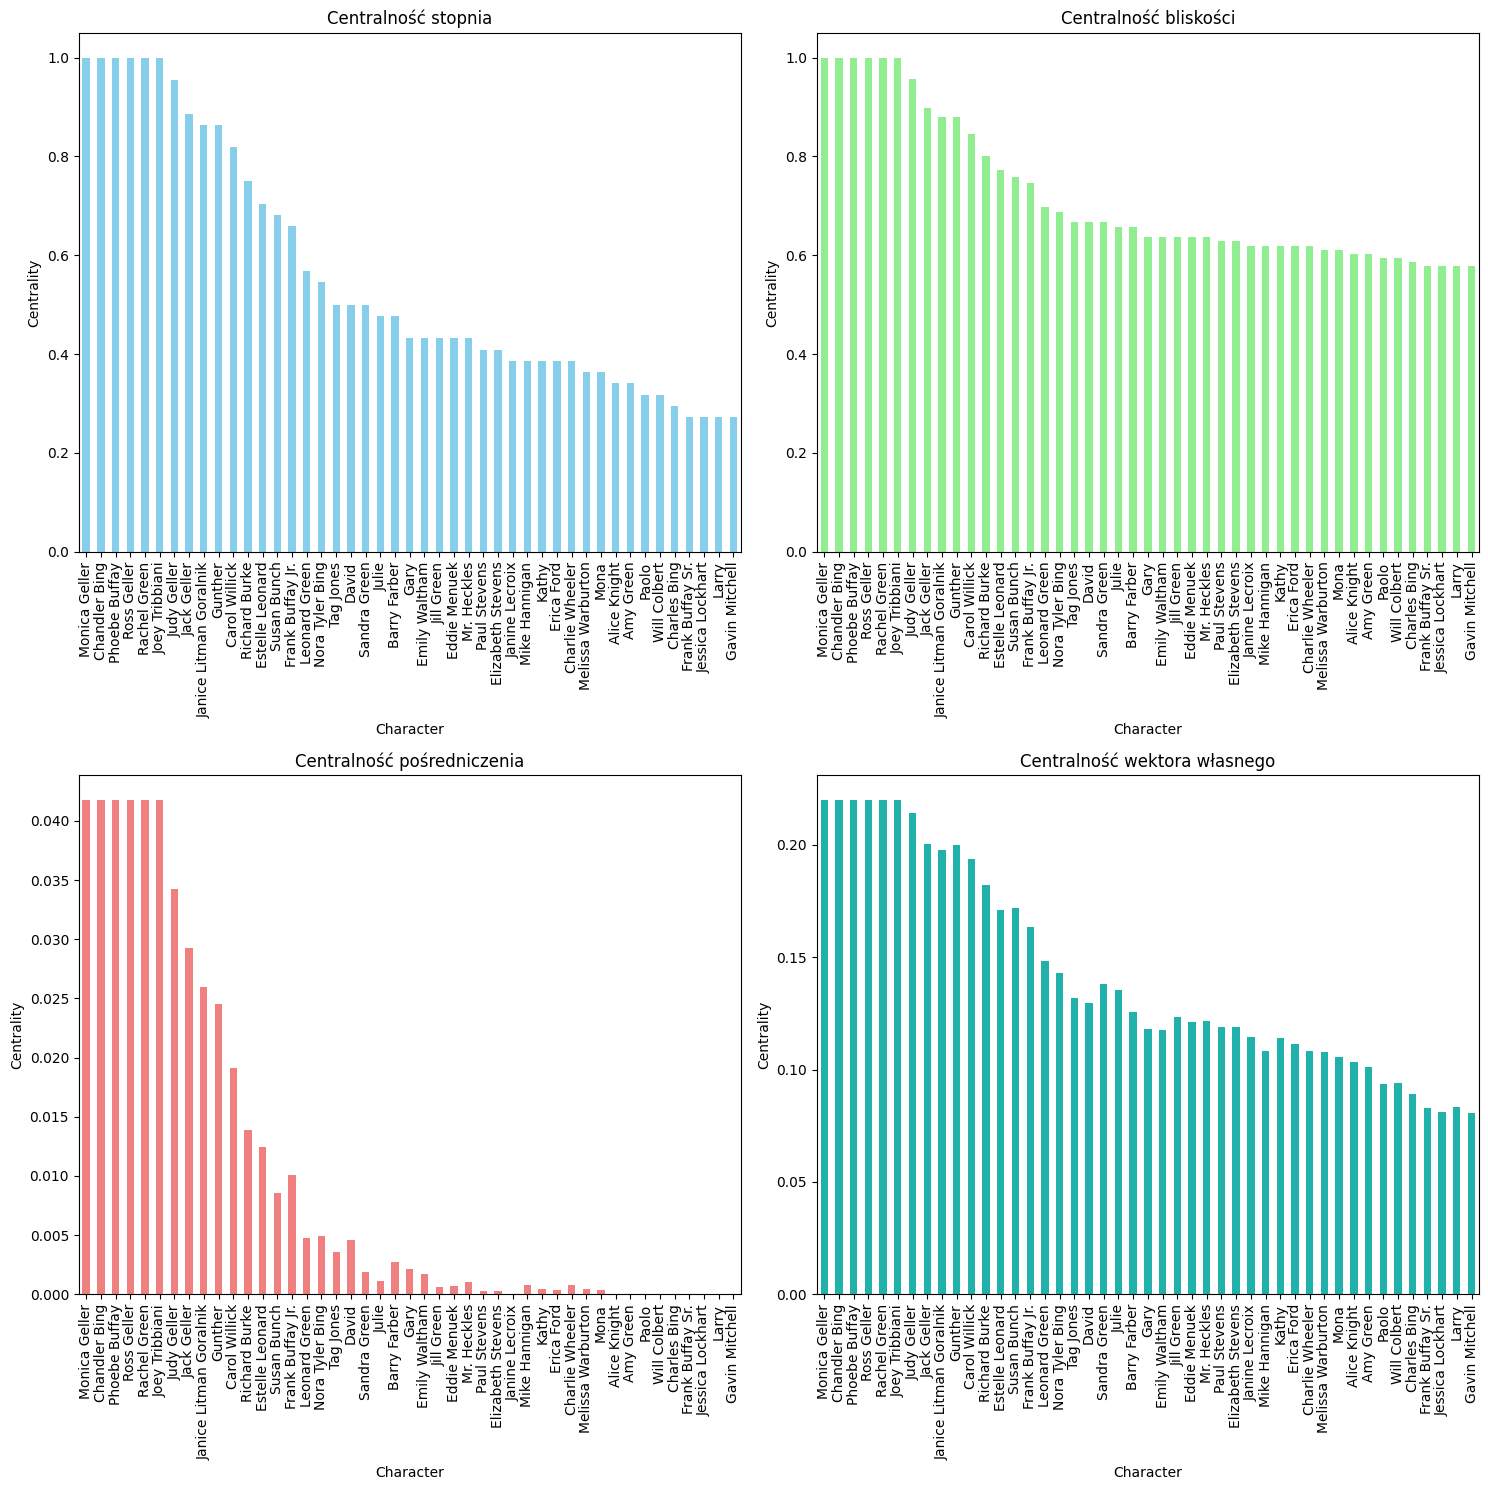

In [89]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Closeness Centrality': closeness_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Eigenvector Centrality': eigenvector_centrality
})

centrality_df = centrality_df.sort_values(by='Degree Centrality', ascending=False)
print(centrality_df)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

centrality_df['Degree Centrality'].plot(kind='bar', ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Centralność stopnia')
axs[0, 0].set_ylabel('Centrality')
axs[0, 0].set_xlabel('Character')

centrality_df['Closeness Centrality'].plot(kind='bar', ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title('Centralność bliskości')
axs[0, 1].set_ylabel('Centrality')
axs[0, 1].set_xlabel('Character')

centrality_df['Betweenness Centrality'].plot(kind='bar', ax=axs[1, 0], color='lightcoral')
axs[1, 0].set_title('Centralność pośredniczenia')
axs[1, 0].set_ylabel('Centrality')
axs[1, 0].set_xlabel('Character')

centrality_df['Eigenvector Centrality'].plot(kind='bar', ax=axs[1, 1], color='lightseagreen')
axs[1, 1].set_title('Centralność wektora własnego')
axs[1, 1].set_ylabel('Centrality')
axs[1, 1].set_xlabel('Character')

plt.tight_layout()
plt.show()

In [90]:
less_than_half_degree_centrality = centrality_df[centrality_df['Degree Centrality'] < 0.5]
less_than_half_degree_centrality.shape[0]

25

Weryfikacja hipotezy: nr 2 (Rachel Green i Ross Geller będą mieli wyższy stopień interakcji w porównaniu do innych par postaci ze względu na ich znaczącą rolę w fabule serialu.) i nr 3 (Chandler Bing i Joey Tribbiani mają większą liczbę interakcji niż Chandler Bing i Phoebe Buffay.),

In [91]:
weight_ross_rachel = G['Ross Geller']['Rachel Green']['weight'] if G.has_edge('Ross Geller', 'Rachel Green') else 0

weight_other_pairs = {}
for u, v, d in G.edges(data=True):
    if (u != 'Ross Geller' and v != 'Rachel Green') and (u != 'Rachel Green' and v != 'Ross Geller'):
        weight_other_pairs[(u, v)] = d['weight']

print(f"Waga krawędzi między Ross Geller i Rachel Green: {weight_ross_rachel}")
#print("Wagi krawędzi między innymi parami postaci:")
#for pair, weight in weight_other_pairs.items():
#    print(f"  {pair}: {weight}")

max_other_pair = max(weight_other_pairs, key=weight_other_pairs.get)
print(f"Największa waga krawędzi między innymi parami postaci: {max_other_pair} z wagą {weight_other_pairs[max_other_pair]}")


Waga krawędzi między Ross Geller i Rachel Green: 173
Największa waga krawędzi między innymi parami postaci: ('Joey Tribbiani', 'Chandler Bing') z wagą 173


In [92]:
weight_chandler_joey = G['Chandler Bing']['Joey Tribbiani']['weight'] if G.has_edge('Chandler Bing', 'Joey Tribbiani') else 0
weight_chandler_phoebe = G['Chandler Bing']['Phoebe Buffay']['weight'] if G.has_edge('Chandler Bing', 'Phoebe Buffay') else 0

print(f"Waga krawędzi między Chandler Bing i Joey Tribbiani: {weight_chandler_joey}")
print(f"Waga krawędzi między Chandler Bing i Phoebe Buffay: {weight_chandler_phoebe}")

if weight_chandler_joey > weight_chandler_phoebe:
    print("Hipoteza potwierdzona: Chandler Bing i Joey Tribbiani mają większą liczbę interakcji niż Chandler Bing i Phoebe Buffay.")
else:
    print("Hipoteza niepotwierdzona: Chandler Bing i Joey Tribbiani nie mają większej liczby interakcji niż Chandler Bing i Phoebe Buffay.")

Waga krawędzi między Chandler Bing i Joey Tribbiani: 173
Waga krawędzi między Chandler Bing i Phoebe Buffay: 168
Hipoteza potwierdzona: Chandler Bing i Joey Tribbiani mają większą liczbę interakcji niż Chandler Bing i Phoebe Buffay.


Odpowiedź na pytanie badawcze: Jakie są najczęstsze wzorce interakcji między kluczowymi parami postaci, takimi jak Ross i Rachel, Monica i Chandler, czy Joey i Phoebe?

In [93]:
pairs = [
    ('Ross Geller', 'Rachel Green'),
    ('Monica Geller', 'Chandler Bing'),
    ('Joey Tribbiani', 'Phoebe Buffay'),
    ('Chandler Bing', 'Joey Tribbiani'),
    ('Chandler Bing', 'Phoebe Buffay')
]

pair_weights = {}
for pair in pairs:
    weight = G[pair[0]][pair[1]]['weight'] if G.has_edge(pair[0], pair[1]) else 0
    pair_weights[pair] = weight

for pair, weight in pair_weights.items():
    print(f"Waga krawędzi między {pair[0]} i {pair[1]}: {weight}")

most_interactions = max(pair_weights, key=pair_weights.get)
print(f"Para z największą liczbą interakcji: {most_interactions[0]} i {most_interactions[1]} z wagą {pair_weights[most_interactions]}")

for pair, weight in pair_weights.items():
    print(f"Liczba interakcji między {pair[0]} i {pair[1]} wynosi: {weight}")

Waga krawędzi między Ross Geller i Rachel Green: 173
Waga krawędzi między Monica Geller i Chandler Bing: 172
Waga krawędzi między Joey Tribbiani i Phoebe Buffay: 169
Waga krawędzi między Chandler Bing i Joey Tribbiani: 173
Waga krawędzi między Chandler Bing i Phoebe Buffay: 168
Para z największą liczbą interakcji: Ross Geller i Rachel Green z wagą 173
Liczba interakcji między Ross Geller i Rachel Green wynosi: 173
Liczba interakcji między Monica Geller i Chandler Bing wynosi: 172
Liczba interakcji między Joey Tribbiani i Phoebe Buffay wynosi: 169
Liczba interakcji między Chandler Bing i Joey Tribbiani wynosi: 173
Liczba interakcji między Chandler Bing i Phoebe Buffay wynosi: 168


Anliza podgrupy w grafie - połaczenia z Rossem aby potem bliżej się przyjrzeć jego związkom

In [94]:
ross_romantic_partners = ['Rachel Green', 'Carol Willick', 'Emily Waltham']

ross_related_nodes = [node for node in G.neighbors('Ross Geller')]

ross_relationships_nodes = [node for node in ross_related_nodes if node in ross_romantic_partners]

ross_relationships_nodes.append('Ross Geller')

ross_relationships_subgraph = G.subgraph(ross_relationships_nodes)

print("Węzły związane z Rossem Gellerem w związkach romantycznych:", ross_relationships_nodes)
print("Liczba węzłów w podgrafie:", len(ross_relationships_subgraph.nodes))
print("Liczba krawędzi w podgrafie:", len(ross_relationships_subgraph.edges))

Węzły związane z Rossem Gellerem w związkach romantycznych: ['Rachel Green', 'Carol Willick', 'Emily Waltham', 'Ross Geller']
Liczba węzłów w podgrafie: 4
Liczba krawędzi w podgrafie: 6


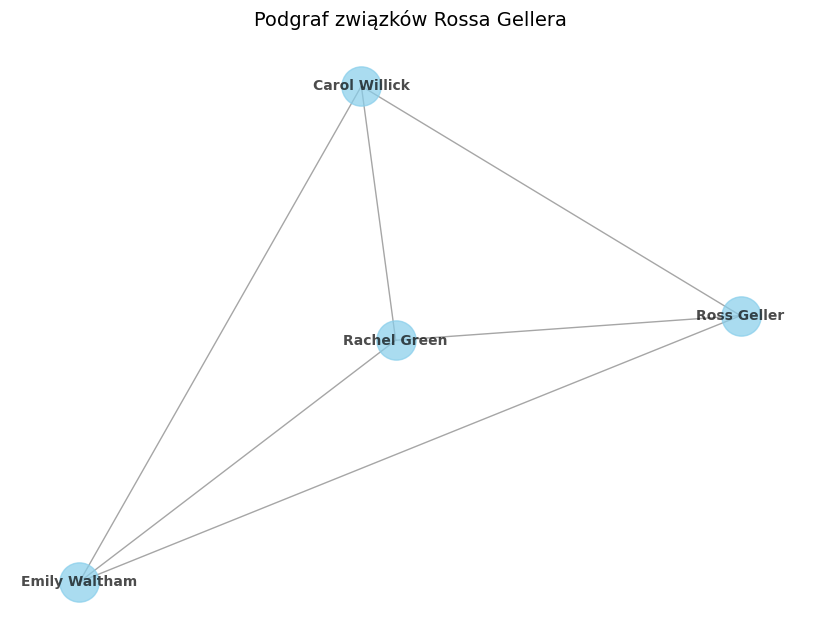

In [95]:
plt.figure(figsize=(8, 6))
nx.draw(ross_relationships_subgraph, with_labels=True, node_color='skyblue', node_size=800, font_size=10, font_weight='bold', edge_color='gray', linewidths=1, alpha=0.7)
plt.title("Podgraf związków Rossa Gellera", fontsize=14)
plt.show()

In [96]:
print(nx.density(ross_relationships_subgraph))
print(nx.transitivity(ross_relationships_subgraph))

1.0
1.0


In [97]:
average_degree = sum(dict(ross_relationships_subgraph.degree()).values()) / len(ross_relationships_subgraph.nodes)
print("Średni stopień wierzchołka:", average_degree)

degree_centrality = nx.degree_centrality(ross_relationships_subgraph)
print("Centralność stopnia dla wierzchołków:")
for node, centrality in degree_centrality.items():
    print(f"{node}: {centrality}")

betweenness_centrality = nx.betweenness_centrality(ross_relationships_subgraph)
print("Centralność pośrednictwa dla wierzchołków:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")

Średni stopień wierzchołka: 3.0
Centralność stopnia dla wierzchołków:
Rachel Green: 1.0
Ross Geller: 1.0
Carol Willick: 1.0
Emily Waltham: 1.0
Centralność pośrednictwa dla wierzchołków:
Rachel Green: 0.0
Ross Geller: 0.0
Carol Willick: 0.0
Emily Waltham: 0.0


In [98]:
def analyze_cliques(subgraph):
    cliques = list(nx.find_cliques(subgraph))
    print("Znalezione kliki:")
    for i, clique in enumerate(cliques, 1):
        print(f"Klika {i}: {clique}")
    largest_clique = max(cliques, key=len)
    print("Największa klika:", largest_clique)
    print("Rozmiar największej klikniętej kliki:", len(largest_clique))

analyze_cliques(ross_relationships_subgraph)

Znalezione kliki:
Klika 1: ['Rachel Green', 'Ross Geller', 'Carol Willick', 'Emily Waltham']
Największa klika: ['Rachel Green', 'Ross Geller', 'Carol Willick', 'Emily Waltham']
Rozmiar największej klikniętej kliki: 4


Wykrywanie wspólnot

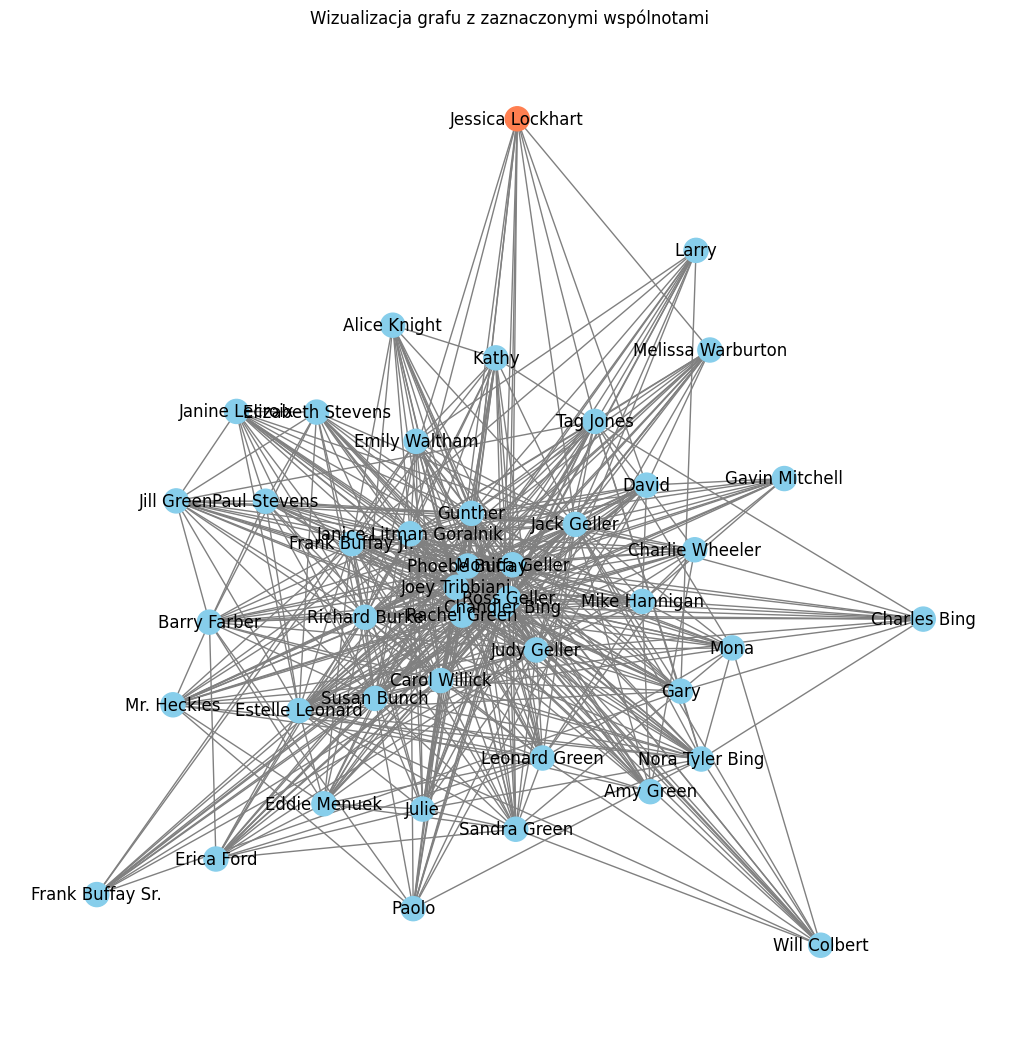

In [101]:
G2 = nx.Graph()

characters = friends_cleaned['speaker'].unique()
G2.add_nodes_from(characters)

for season, group in friends_cleaned.groupby('season'):
    for scene, scene_group in group.groupby('scene'):
        characters_in_scene = scene_group['speaker'].unique()
        for combination in combinations(characters_in_scene, 2):
            if G2.has_edge(*combination):
                G2[combination[0]][combination[1]]['weight'] += 1
            else:
                G2.add_edge(*combination, weight=1)

communities = girvan_newman(G2)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

color_map = []
for node in G2:
    if node in node_groups[0]:
        color_map.append('skyblue')
    elif node in node_groups[1]:
        color_map.append('coral')
    else:
        color_map.append('olive')

plt.figure(figsize=(10, 10))
nx.draw_spring(G2, node_color=color_map, with_labels=True, edge_color='gray')
plt.title('Wizualizacja grafu z zaznaczonymi wspólnotami')
plt.show()

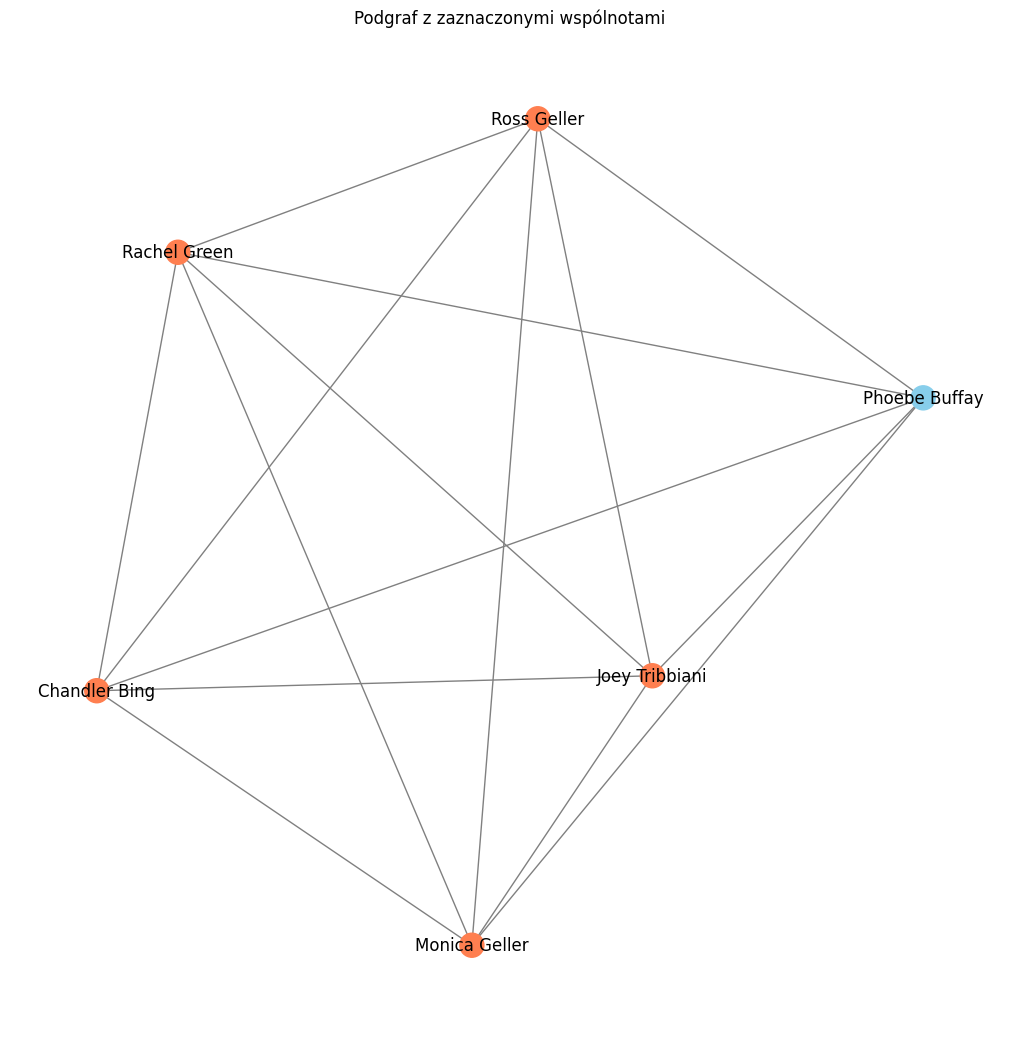

In [103]:
main_characters = ['Monica Geller', 'Rachel Green', 'Chandler Bing', 'Joey Tribbiani', 'Ross Geller', 'Phoebe Buffay']
main_subgraph = G.subgraph(main_characters)

communities = nx.algorithms.community.girvan_newman(main_subgraph)
community_assignment = {}
for idx, community in enumerate(next(communities)):
    for node in community:
        community_assignment[node] = idx
colors = ['skyblue', 'coral', 'olive', 'lightgreen', 'orange', 'lightblue']
node_colors = [colors[community_assignment[node]] for node in main_subgraph.nodes()]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(main_subgraph)
nx.draw(main_subgraph, pos, node_color=node_colors, with_labels=True, edge_color='gray')
plt.title('Podgraf z zaznaczonymi wspólnotami')
plt.show()

In [104]:
print("Liczba węzłów w podgrafie:", len(main_subgraph.nodes))
print("Liczba krawędzi w podgrafie:", len(main_subgraph.edges))
print(nx.density(main_subgraph))
print(nx.transitivity(main_subgraph))

Liczba węzłów w podgrafie: 6
Liczba krawędzi w podgrafie: 15
1.0
1.0


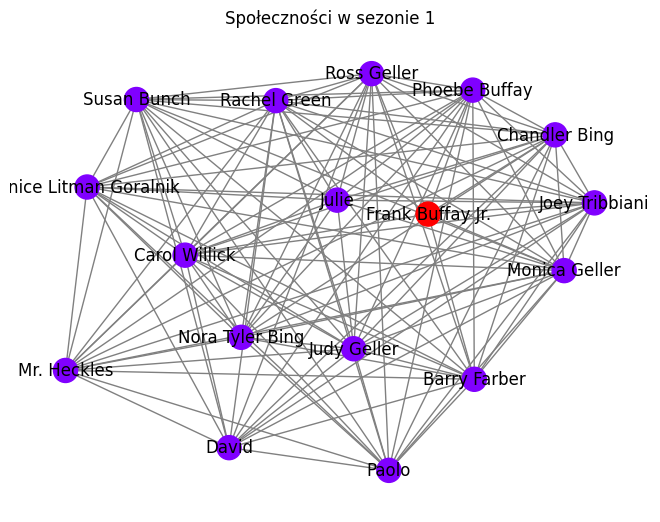

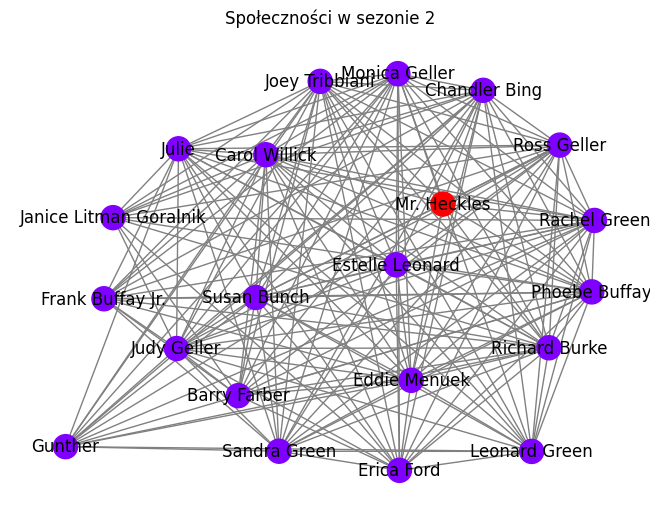

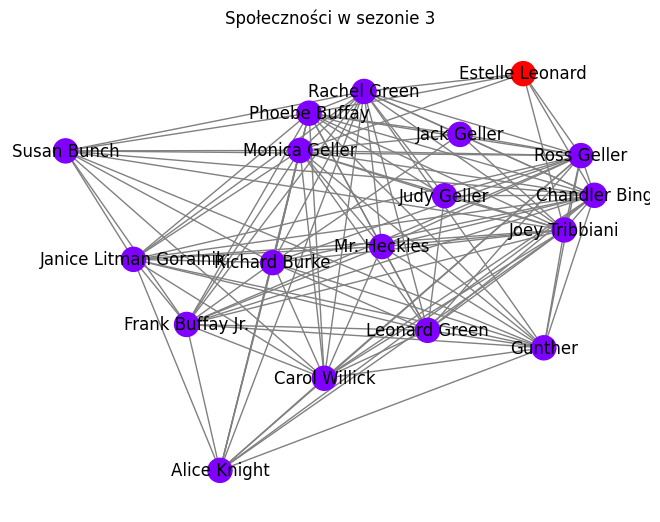

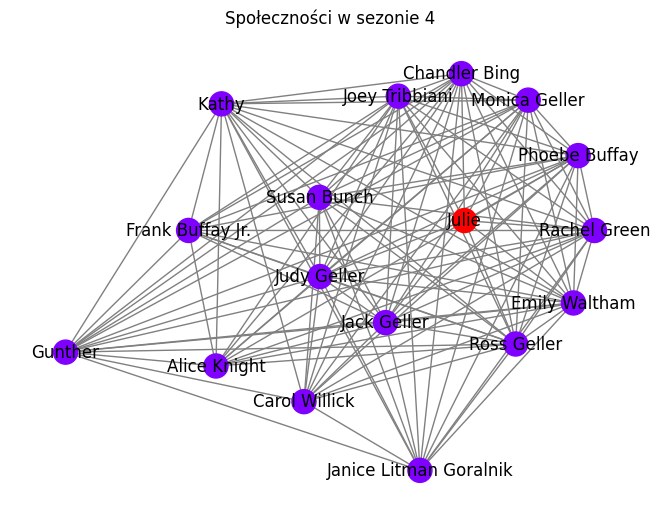

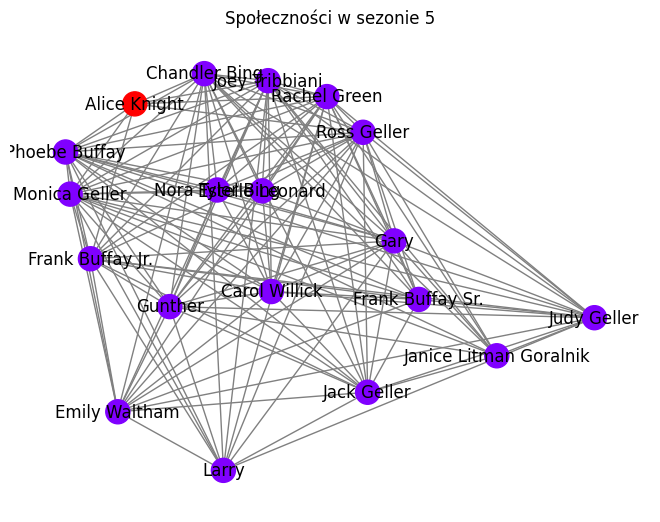

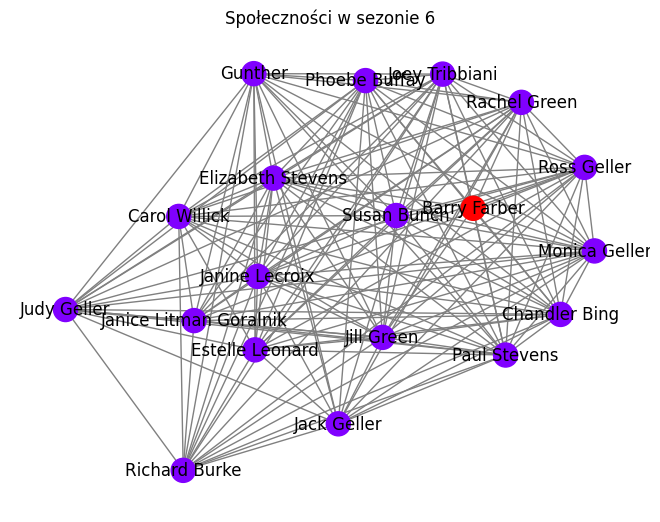

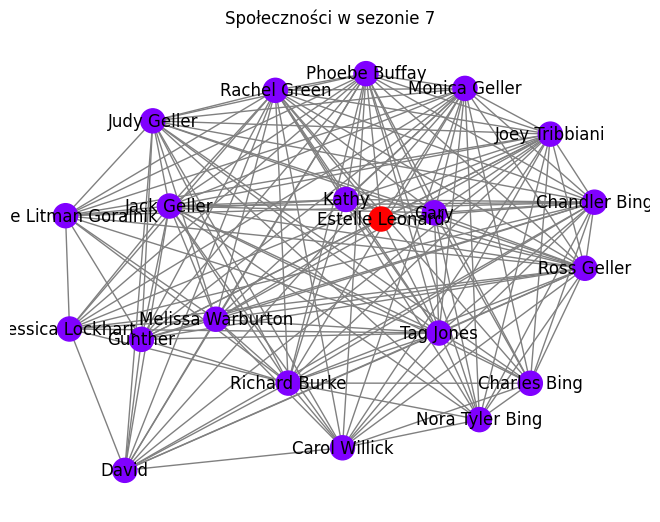

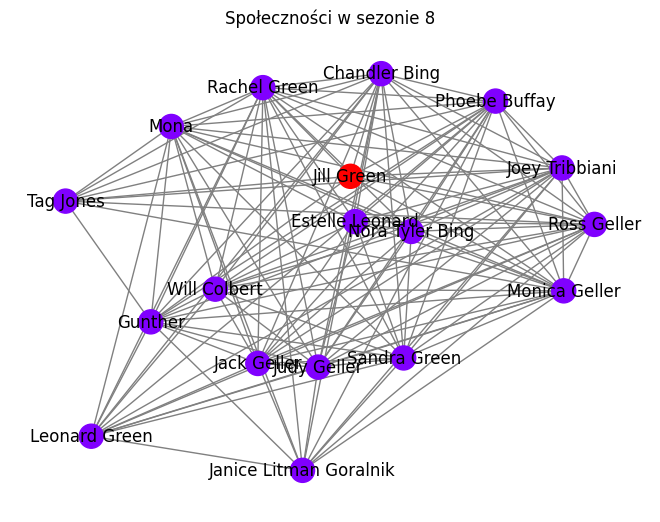

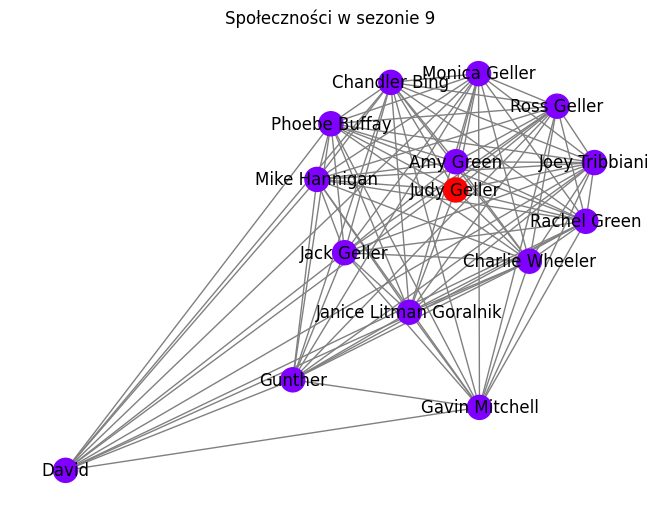

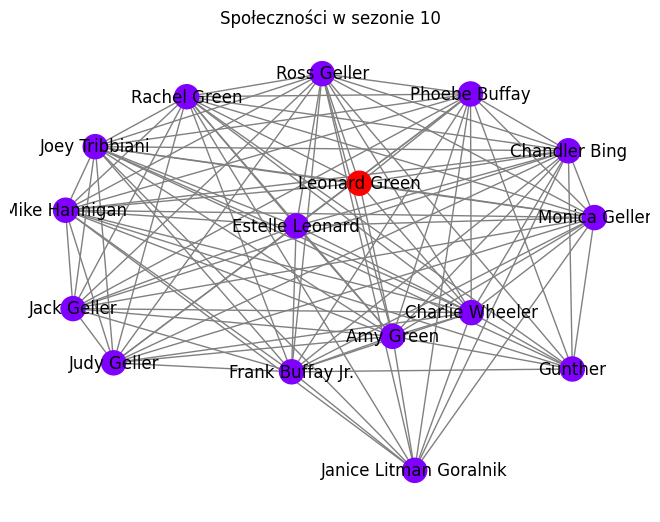

Centralność w pierwszym sezonie:
                        Centralność stopnia  Centralność pośredniczenia  \
Monica Geller                        1.0000                    0.012229   
Chandler Bing                        1.0000                    0.012229   
Phoebe Buffay                        1.0000                    0.012229   
Ross Geller                          1.0000                    0.012229   
Rachel Green                         1.0000                    0.012229   
Carol Willick                        1.0000                    0.012229   
Joey Tribbiani                       1.0000                    0.012229   
Barry Farber                         0.9375                    0.007933   
Janice Litman Goralnik               0.9375                    0.003747   
Susan Bunch                          0.9375                    0.003747   
Judy Geller                          0.9375                    0.003747   
Mr. Heckles                          0.8750                    0.00

In [126]:
def create_graph_for_season(friends_data, season):
    G3 = nx.Graph()
    season_data = friends_data[friends_data['season'] == season]
    characters = season_data['speaker'].unique()
    G3.add_nodes_from(characters)

    for _, scene_group in season_data.groupby('scene'):
        characters_in_scene = scene_group['speaker'].unique()
        for combination in combinations(characters_in_scene, 2):
            if G3.has_edge(*combination):
                G3[combination[0]][combination[1]]['weight'] += 1
            else:
                G3.add_edge(*combination, weight=1)
    return G3


G3_season_1 = create_graph_for_season(friends_cleaned, 1)
G3_season_2 = create_graph_for_season(friends_cleaned, 2)
G3_season_3 = create_graph_for_season(friends_cleaned, 3)
G3_season_4 = create_graph_for_season(friends_cleaned, 4)
G3_season_5 = create_graph_for_season(friends_cleaned, 5)
G3_season_6 = create_graph_for_season(friends_cleaned, 6)
G3_season_7 = create_graph_for_season(friends_cleaned, 7)
G3_season_8 = create_graph_for_season(friends_cleaned, 8)
G3_season_9 = create_graph_for_season(friends_cleaned, 9)
G3_season_10 = create_graph_for_season(friends_cleaned, 10)

def analyze_graph(G):
    communities_generator = nx.algorithms.community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    partition_list = [list(community) for community in top_level_communities]

    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    results = {
        'partition': partition_list,
        'degree_centrality': degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'eigenvector_centrality': eigenvector_centrality
    }

    return results


results_season_1 = analyze_graph(G3_season_1)
results_season_2 = analyze_graph(G3_season_2)
results_season_3 = analyze_graph(G3_season_3)
results_season_4 = analyze_graph(G3_season_4)
results_season_5 = analyze_graph(G3_season_5)
results_season_6 = analyze_graph(G3_season_6)
results_season_7 = analyze_graph(G3_season_7)
results_season_8 = analyze_graph(G3_season_8)
results_season_9 = analyze_graph(G3_season_9)
results_season_10 = analyze_graph(G3_season_10)

def draw_communities(G, partition, title):
    pos = nx.kamada_kawai_layout(G)
    color_map = []
    for node in G:
        for idx, community in enumerate(partition):
            if node in community:
                color_map.append(idx)
    nx.draw(G, pos, node_color=color_map, with_labels=True, cmap=plt.cm.rainbow, edge_color='gray')
    plt.title(title)
    plt.show()

draw_communities(G3_season_1, results_season_1['partition'], 'Społeczności w sezonie 1')
draw_communities(G3_season_2, results_season_2['partition'], 'Społeczności w sezonie 2')
draw_communities(G3_season_3, results_season_3['partition'], 'Społeczności w sezonie 3')
draw_communities(G3_season_4, results_season_4['partition'], 'Społeczności w sezonie 4')
draw_communities(G3_season_5, results_season_5['partition'], 'Społeczności w sezonie 5')
draw_communities(G3_season_6, results_season_6['partition'], 'Społeczności w sezonie 6')
draw_communities(G3_season_7, results_season_7['partition'], 'Społeczności w sezonie 7')
draw_communities(G3_season_8, results_season_8['partition'], 'Społeczności w sezonie 8')
draw_communities(G3_season_9, results_season_9['partition'], 'Społeczności w sezonie 9')
draw_communities(G3_season_10, results_season_10['partition'], 'Społeczności w sezonie 10')

centrality_df_1 = pd.DataFrame({
    'Centralność stopnia': results_season_1['degree_centrality'],
    'Centralność pośredniczenia': results_season_1['betweenness_centrality'],
    'Centralność wektora własnego': results_season_1['eigenvector_centrality']
}).sort_values(by='Centralność stopnia', ascending=False)

centrality_df_10 = pd.DataFrame({
    'Centralność stopnia': results_season_10['degree_centrality'],
    'Centralność pośredniczenia': results_season_10['betweenness_centrality'],
    'Centralność wektora własnego': results_season_10['eigenvector_centrality']
}).sort_values(by='Centralność stopnia', ascending=False)

print("Centralność w pierwszym sezonie:")
print(centrality_df_1)

print("Centralność w dziesiątym sezonie:")
print(centrality_df_10)